# Imports

In [63]:
import sys
import os
import gc
import time
import random
import re
from tqdm import tqdm 
import json
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForCausalLM, LlamaTokenizer, LlamaForCausalLM, BatchEncoding
import matplotlib.pyplot as plt
from math import ceil
from sentence_transformers import SentenceTransformer

In [9]:
sys.path.append("/coc/pskynet6/dhe83/mice/src")

In [70]:
import config
import utils
from prompts import *

## Load Data

In [11]:
train = utils.read_jsonl("../data/BoolQ/train.jsonl")
train = {str(ex['idx']): ex for ex in train}
val = utils.read_jsonl("../data/BoolQ/val.jsonl")
val = {str(ex['idx']): ex for ex in val}

## Load Model

In [71]:
model_addr = "decapoda-research/llama-7b-hf"
tokenizer = LlamaTokenizer.from_pretrained(model_addr, use_fast=False, padding_side='left')
model = LlamaForCausalLM.from_pretrained(
    model_addr,
    load_in_8bit=True,
    torch_dtype=torch.float16,
    device_map='auto'
)
print("done!")

normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


Loading checkpoint shards:   0%|          | 0/33 [00:00<?, ?it/s]

done!


In [13]:
model.config

LlamaConfig {
  "_name_or_path": "decapoda-research/llama-7b-hf",
  "architectures": [
    "LLaMAForCausalLM"
  ],
  "bos_token_id": 0,
  "eos_token_id": 1,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 11008,
  "max_position_embeddings": 2048,
  "max_sequence_length": 2048,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "pad_token_id": -1,
  "quantization_config": {
    "llm_int8_enable_fp32_cpu_offload": false,
    "llm_int8_skip_modules": null,
    "llm_int8_threshold": 6.0,
    "load_in_8bit": true
  },
  "rms_norm_eps": 1e-06,
  "tie_word_embeddings": false,
  "torch_dtype": "float16",
  "transformers_version": "4.29.2",
  "use_cache": true,
  "vocab_size": 32000
}

In [91]:
# unwind broken decapoda-research config
model.config.pad_token_id = tokenizer.pad_token_id = 0  # unk
model.config.bos_token_id = 1
model.config.eos_token_id = 2

In [92]:
# model.half()
model.eval()
if torch.__version__ >= "2" and sys.platform != "win32":
    model = torch.compile(model)

# In-Context Analysis

In [19]:
def tokenize_progressive(dem, test):
    dem_tokens = tokenizer(dem, padding=True,return_tensors="pt").to('cuda')
    prompt_tokens = tokenizer(test, padding=True,return_tensors="pt").to('cuda')
    
    def progressive_context(input_ids):
        token_len = input_ids.shape[1]
        
        repeated = input_ids.repeat(token_len, 1)
        offset = torch.arange(token_len).unsqueeze(dim=-1).cuda()
        indices = torch.arange(token_len).repeat(token_len,1).cuda()
        
        indices = (indices - offset) % token_len
        
        tokens = torch.gather(repeated, -1, indices).triu()
        attention_mask = torch.ones_like(tokens).triu()
        
        return tokens.flip((0)), attention_mask.flip((0))

    def pad_demonstration(input_ids, mask):
        return F.pad(input_ids, (0,2), "constant", 13), F.pad(mask, (0,2), "constant", 1)
    
    context_ids, context_mask = progressive_context(dem_tokens.input_ids)
    context_ids, context_mask = pad_demonstration(context_ids, context_mask)
    
    no_pad = prompt_tokens.input_ids[:, 1:]
    repeated = no_pad.repeat(context_ids.shape[0], 1)
    mask_repeated = torch.ones_like(repeated)
    
    inputs = torch.cat((context_ids, repeated), 1)
    mask = torch.cat((context_mask, mask_repeated), 1)
    return BatchEncoding({'input_ids': inputs, 'attention_mask': mask})


In [ ]:
def inference_wrapper(prompts: dict):
    prompts = {k: v for k, v in sorted(x.items(), key=lambda item: len(item[1]))}

def batch_inference(model, tokenizer, prompts, batch_size, mask_bos):
output_tokens = torch.empty(0, dtype=torch.int64).to('cuda:0')
first_token_scores = []
num_batches = ceil(len(prompts) / batch_size)

for batch in range(num_batches):
    start = batch * batch_size
    end = min((batch + 1) * batch_size, len(prompts))

    gen_len=5
    # tokenize by batch to mitigate effect of long outliers
    tokens = tokenizer(prompts[start:end], padding=True, return_tensors="pt").to('cuda:0')
    attention_mask = masked_bos(tokens.attention_mask) if mask_bos else tokens.attention_mask

    with torch.no_grad():
        outputs = model.generate(
            input_ids=tokens.input_ids,
            attention_mask=attention_mask,
            max_new_tokens=gen_len,
            temperature=0,
            return_dict_in_generate=True,
            output_scores=True,
        )
    output_tokens = torch.cat((output_tokens, outputs.sequences[:, -gen_len:]))
output_text = tokenizer.batch_decode(output_tokens)
return output_text      

In [125]:
def batch_inference(tokenized):    
    batch_size=16
    num_prompts = tokenized.input_ids.shape[0]
    num_batches = ceil(num_prompts / batch_size)
    output_tokens = torch.empty(0, dtype=torch.int64).to('cuda:0')
    output_scores = torch.empty(0, dtype=torch.float16).to('cuda:0')
    
    for batch in tqdm(range(num_batches)): 
        start = batch * batch_size
        end = min((batch + 1) * batch_size, num_prompts)
        
        # tokenize by batch to mitigate effect of long outliers
        input_ids = tokenized.input_ids[start:end, :]
        mask = tokenized.attention_mask[start:end, :]
        outputs = model.generate(
            input_ids=input_ids,
            attention_mask=mask,
            max_new_tokens=0,
            temperature=0,
            return_dict_in_generate=True,
            output_scores=True,
        )
        output_tokens = torch.cat((output_tokens, outputs.sequences[:, -1].to('cuda:0')))
        output_scores = torch.cat((output_scores, outputs.scores[0].to('cuda:0')), dim=0)
        
    return output_tokens, output_scores

In [116]:
encoder = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2").to("cuda")
def embed(data, dataset, model):
    print("Embedding train examples...", end="")
    embeddings = {}
    for idx, ex in tqdm(data.items()):
#         train_prompt = format_in_context(train_example, dataset)
        text = ex['question']
        embeddings[idx] = torch.tensor(model.encode(text))
    print("done!")
    return embeddings
    
def similarity_scores(test_example, embeddings, dataset, model):
#     test_prompt = format_example(test_example, dataset)
    test_prompt = test_example['question']
    test_embedding = torch.tensor(model.encode(test_prompt))
    train_embeddings = embeddings

    similarity = torch.nn.CosineSimilarity(dim=1)
    
    print("Scoring similarity...", end="")
    similarity_list = sorted([(idx, similarity(
                                test_embedding.unsqueeze(0),
                                train_embedding.unsqueeze(0),).item())
                                for idx, train_embedding in tqdm(train_embeddings.items())], 
                             key=lambda x: x[1], reverse=True)
    print("done!")
    
    return similarity_list

### Zero-Shot

In [135]:
single = tokenizer(test, return_tensors="pt").to('cuda:0')
single_output = model.generate(
    **single,
    max_new_tokens=5,
    temperature=0,
    return_dict_in_generate=True,
    output_scores=True,
)
text = tokenizer.decode(single_output.sequences[0, :])

In [139]:
scores = single_output.scores[0]

In [148]:
scores[0]

tensor([-7.0781, -9.8359,  3.6426,  ..., -0.8032, -2.9844, -1.2031],
       device='cuda:0', dtype=torch.float16)

In [144]:
yes = [3869, 4874, 5852, 1565]
no = [1939, 694, 7700, 2089]

probs = scores[0].log_softmax(-1).exp()
yes_probs = probs[yes].sum(-1)
no_probs = probs[no].sum(-1)

In [146]:
yes_probs.item()

0.26171875

In [147]:
no_probs.item()

0.130615234375

### Progressive Prompting

In [123]:
def plot_progressive(dem, test):
    yes = [3869, 4874, 5852, 1565]
    no = [1939, 694, 7700, 2089]
    
    
    tokens = tokenize_progressive("\n\n".join(dem), test)
    sequences, scores = batch_inference(tokens)
    
    print("\n\n".join([*dem, test]))
    print(tokenizer.decode(sequences[-1]))
    
    probs = scores.log_softmax(-1).exp()
    yes_probs = probs[:, yes].sum(-1)
    no_probs = probs[:, no].sum(-1)
    
    plt.plot(yes_probs.cpu(), color='green', label='Yes')
    plt.plot(no_probs.cpu(), color='red', label='No')

    plt.xlabel('Tokens')
    plt.ylabel('Probability')
    plt.title('Answer Probs')

    plt.legend()
    plt.show()

In [122]:
ic1 = prompts.format_BoolQ_in_context(train['3908'])
ic2 = prompts.format_BoolQ_in_context(train['5981'])

ex = val['2953']
test = prompts.format_BoolQ(ex)

In [ ]:
train_embeddings = embed(train, "BoolQ", encoder)

In [117]:
similarity_list = similarity_scores(val['2953'], train_embeddings, "BoolQ", encoder)

Scoring similarity...



  0%|                                                                       | 0/9427 [00:00<?, ?it/s]

 36%|████████████████████▎                                    | 3358/9427 [00:00<00:00, 33569.79it/s]

100%|█████████████████████████████████████████████████████████| 9427/9427 [00:00<00:00, 33213.36it/s]

done!


In [118]:
for x in similarity_list[:10]:
    print(x[0], format_in_context(train[str(x[0])], "BoolQ"))
    print("*" * 20)

4858 Remember the Titans -- Remember the Titans is a 2000 American biographical sports drama film produced by Jerry Bruckheimer and directed by Boaz Yakin. The screenplay, written by Gregory Allen Howard, is based on the true story of African-American coach Herman Boone, portrayed by Denzel Washington, and his attempt to integrate the T.C. Williams High School football team in Alexandria, Virginia, in 1971. Will Patton portrays Bill Yoast, Boone's assistant coach. Real-life athletes Gerry Bertier and Julius Campbell are portrayed by Ryan Hurst and Wood Harris, respectively.
question: was the movie remember the titans a true story
answer: yes
********************
4228 Remember Me (2010 film) -- Remember Me is a 2010 American romantic coming-of-age drama film directed by Allen Coulter, and screenplay by Will Fetters. It stars Robert Pattinson, Emilie de Ravin, Chris Cooper, Lena Olin and Pierce Brosnan.
question: is the movie remember me based on a book
answer: no
********************
16



  0%|                                                                         | 0/16 [00:00<?, ?it/s]

  6%|████                                                             | 1/16 [00:01<00:24,  1.67s/it]

 12%|████████▏                                                        | 2/16 [00:03<00:23,  1.67s/it]

 19%|████████████▏                                                    | 3/16 [00:04<00:21,  1.67s/it]

 25%|████████████████▎                                                | 4/16 [00:06<00:19,  1.67s/it]

 31%|████████████████████▎                                            | 5/16 [00:08<00:18,  1.67s/it]

 38%|████████████████████████▍                                        | 6/16 [00:09<00:16,  1.67s/it]

 44%|████████████████████████████▍                                    | 7/16 [00:11<00:15,  1.67s/it]

 50%|████████████████████████████████▌                                | 8/16 [00:13<00:13,  1.67s/it]

 56%|████████████████████████████████████▌                            |

Remember Me (2010 film) -- Remember Me is a 2010 American romantic coming-of-age drama film directed by Allen Coulter, and screenplay by Will Fetters. It stars Robert Pattinson, Emilie de Ravin, Chris Cooper, Lena Olin and Pierce Brosnan.
question: is the movie remember me based on a true story
answer: no

About Time (2013 film) -- By Curtis's own admission the conception of the idea ``was a slow growth''. The genesis of the idea came when Curtis was eating lunch with a friend and the subject of happiness came up. Upon admitting he was not truly happy in life, the conversation turned towards him describing an ideal day. From here Curtis realized that the day of the lunch, for him, constituted such a day, which led to him deciding to write a film about ``how you achieve happiness in ordinary life''. Thinking that the concept was too ``simple'' he decided to add a time travel element to the film.
question: is the movie about time based on a book
answer: no

Remember the Titans -- Remembe

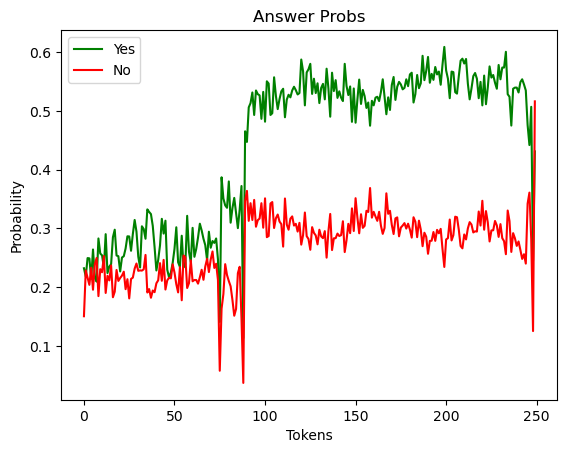

In [124]:
plot_progressive([ic1, ic2], test)

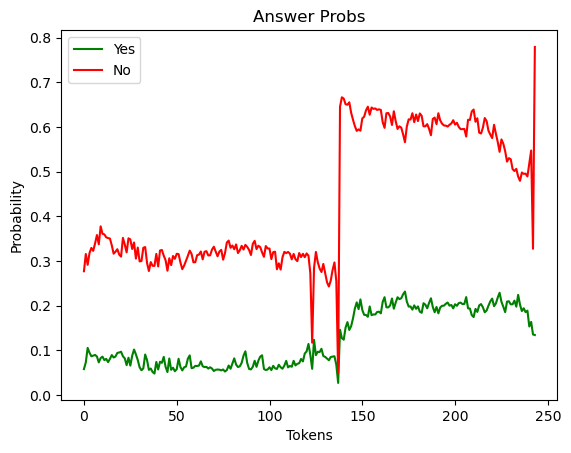

In [109]:
#no_no
plt.plot(saved_yes["no_no"].cpu(), color='green', label='Yes')
plt.plot(saved_no["no_no"].cpu(), color='red', label='No')

plt.xlabel('Tokens')
plt.ylabel('Probability')
plt.title('Answer Probs (No, No)')

plt.legend()
plt.show()

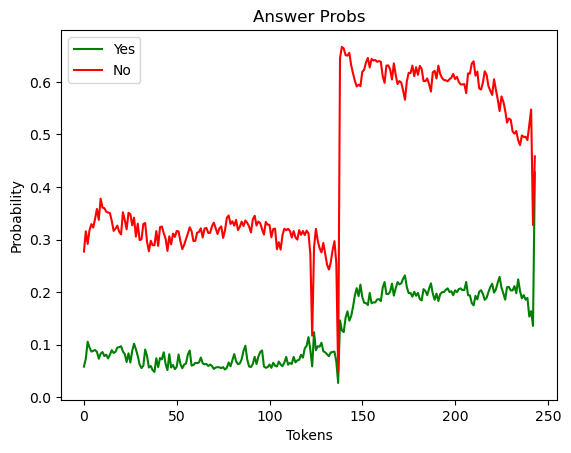

In [108]:
#no_yes
plt.plot(saved_yes["no_yes"].cpu(), color='green', label='Yes')
plt.plot(saved_no["no_yes"].cpu(), color='red', label='No')

plt.xlabel('Tokens')
plt.ylabel('Probability')
plt.title('Answer Probs')

plt.legend()
plt.show()

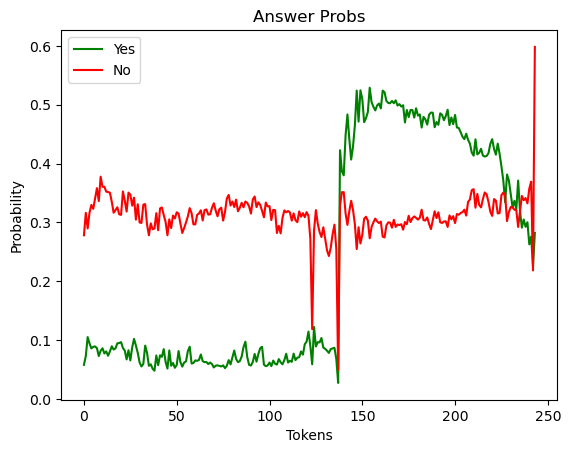

In [88]:
#yes_no
plt.plot(saved_yes["yes_no"].cpu(), color='green', label='Yes')
plt.plot(saved_no["yes_no"].cpu(), color='red', label='No')

plt.xlabel('Tokens')
plt.ylabel('Probability')
plt.title('Answer Probs')

plt.legend()
plt.show()

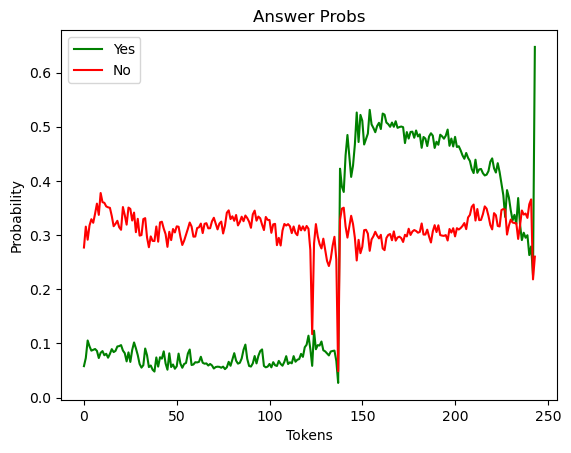

In [106]:
#yes_yes
plt.plot(saved_yes["yes_yes"].cpu(), color='green', label='Yes')
plt.plot(saved_no["yes_yes"].cpu(), color='red', label='No')

plt.xlabel('Tokens')
plt.ylabel('Probability')
plt.title('Answer Probs')

plt.legend()
plt.show()

In [12]:
print(torch.cuda.mem_get_info())
print(torch.cuda.memory_summary())

(33877721088, 47850782720)
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   10091 MB |   11107 MB |   38327 MB |   28235 MB |
|       from large pool |   10088 MB |   11104 MB |   38320 MB |   28232 MB |
|       from small pool |       3 MB |       4 MB |       7 MB |       3 MB |
|---------------------------------------------------------------------------|
| Active memory         |   10091 MB |   11107 MB |   38327 MB |   28235 MB |
|       from large pool |   10088 MB 

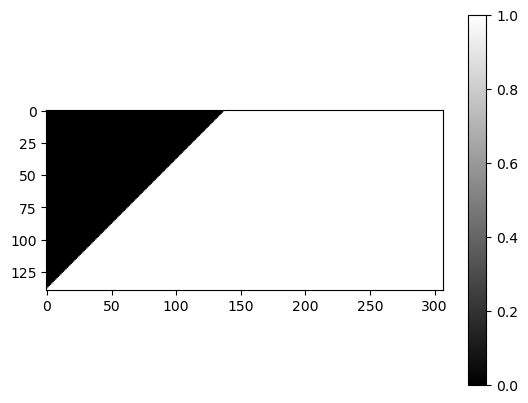

In [120]:
plt.imshow(mask.cpu().numpy(), cmap='gray')
plt.colorbar()
plt.show()

In [ ]:
def scores(inputs, outputs):
    transition_scores = model.compute_transition_scores(
        outputs.sequences, outputs.scores, normalize_logits=True
    )
    # input_length is the length of the input prompt for decoder-only models, like the GPT family, and 1 for
    # encoder-decoder models, like BART or T5.
    input_length = inputs.input_ids.shape[1]
    generated_tokens = outputs.sequences[:, input_length:]
    probs = {}
    print(generated_tokens)
    for tok, score in zip(generated_tokens[0], transition_scores[0]):
        # | token | token string | logits | probability
        print(f"| {tok:5d} | {tokenizer.decode(tok):8s} | {score:.3f} | {torch.exp(score):.2%}")
        probs[tokenizer.decode(tok)] = torch.exp(score).item()
    return probs

In [ ]:
q1 = "question: is a aba number the same as a routing number\nanswer:"
q2 = "question: is the vampire diaries related to the originals\nanswer:"
qs = [q1, q2]
ans = [" yes", " no"]
iclist = [q + a for q in [*qs, *reversed(qs)] for a in [*ans, *ans]]

In [ ]:
def batch_inference(tokenized):    
    batch_size=16
    num_prompts = tokenized.input_ids.shape[0]
    num_batches = ceil(num_prompts / batch_size)
    output_tokens = torch.empty(0, dtype=torch.int64).to('cuda:0')
    output_scores = torch.empty(0, dtype=torch.float16).to('cuda:0')
    
    for batch in tqdm(range(num_batches)): 
        start = batch * batch_size
        end = min((batch + 1) * batch_size, num_prompts)
        
        # tokenize by batch to mitigate effect of long outliers
        input_ids = tokenized.input_ids[start:end, :]
        mask = tokenized.attention_mask[start:end, :]
        outputs = model.generate(
            input_ids=input_ids,
            attention_mask=mask,
            max_new_tokens=1,
            temperature=0,
            return_dict_in_generate=True,
            output_scores=True,
        )
        output_tokens = torch.cat((output_tokens, outputs.sequences[:, -1]))
        output_scores = torch.cat((output_scores, outputs.scores[0]), dim=0)
        
    return output_tokens, output_scores